In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from scipy.cluster.vq import whiten, kmeans2  # импортируем библиотеки для анализа

In [3]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()
        return json[result_key]
    except:
        print(json)
        return None

### Получаем команды

In [4]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players'},
   'self': {'href

### Для каждой команды получаем игроков, голы, победы, проигрыши и общее число игр сыграных

In [5]:
for team in teams:
    
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    goals = 0
    win = 0
    lose = 0
    matches = 0
    
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            goals += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            goals += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
  
        if team['name'] == f['homeTeamName']:
            if f['result']['goalsHomeTeam']: 
                if f['result']['goalsHomeTeam'] > f['result']['goalsAwayTeam']:
                    win += 1
                else:
                    lose += 1
        else:
            if f['result']['goalsAwayTeam']: 
                if f['result']['goalsHomeTeam'] < f['result']['goalsAwayTeam']:
                    win += 1
                else:
                    lose += 1
        if f['status'] == 'FINISHED':
            matches += 1
            
    print('Team "{}", {} players, {} goals, {} wins, {} lose, {} played matches'.
          format(team['name'], len(players), goals, win, lose, matches ))
    
    team['players'] = players
    team['goals'] = goals
    team['wins'] = win
    team['loses'] = lose
    team['played matches'] = matches

Team "FC Rio Ave", 30 players, 1 goals, 1 wins, 0 lose, 1 played matches
Team "FC Porto", 20 players, 0 goals, 0 wins, 0 lose, 0 played matches
Team "Moreirense FC", 28 players, 1 goals, 0 wins, 1 lose, 1 played matches
Team "FC Paços de Ferreira", 30 players, 0 goals, 0 wins, 0 lose, 1 played matches
Team "Sporting CP", 25 players, 2 goals, 1 wins, 0 lose, 1 played matches
Team "Maritimo Funchal", 30 players, 1 goals, 1 wins, 0 lose, 1 played matches
Team "CD Tondela", 26 players, 1 goals, 0 wins, 1 lose, 1 played matches
Team "SL Benfica", 25 players, 0 goals, 0 wins, 0 lose, 0 played matches
Team "Boavista Porto FC", 29 players, 1 goals, 0 wins, 1 lose, 1 played matches
Team "FC Arouca", 27 players, 33 goals, 9 wins, 13 lose, 34 played matches
Team "Vitoria Setubal", 26 players, 1 goals, 0 wins, 1 lose, 1 played matches
Team "C.F. Os Belenenses", 25 players, 0 goals, 0 wins, 0 lose, 1 played matches
Team "Vitoria Guimaraes", 24 players, 0 goals, 0 wins, 0 lose, 0 played matches
Team

Готовим данные для трансформации в Pandas

In [6]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append(
            {'names': team['name'], 
             'players': len(team['players']), 
             'goals': team['goals'],
            'played matches' : team['played matches'],
            'loses' : team['loses'],
            'wins' : team['wins']}
        )

### Трансформируем

In [7]:
teams_pd = pd.DataFrame(team_for_pd)

def count_to_len(row):
    return len([i for i in row.names if i!=' '])

teams_pd['len name team'] = teams_pd.apply(count_to_len, axis=1) # добавим длину названия команды
teams_pd

,goals,loses,names,played matches,players,wins,len name team
0,1,0,FC Rio Ave,1,30,1,8
1,0,0,FC Porto,0,20,0,7
2,1,1,Moreirense FC,1,28,0,12
3,0,0,FC Paços de Ferreira,1,30,0,17
4,2,0,Sporting CP,1,25,1,10
5,1,0,Maritimo Funchal,1,30,1,15
6,1,1,CD Tondela,1,26,0,9
7,0,0,SL Benfica,0,25,0,9
8,1,1,Boavista Porto FC,1,29,0,15
9,33,13,FC Arouca,34,27,9,8


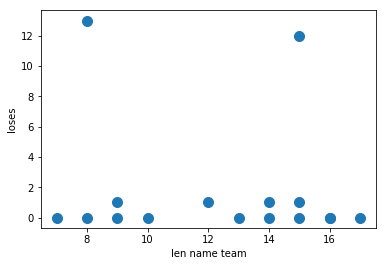

In [8]:
teams_pd.plot.scatter(x='len name team', y='loses', s=100)

### Удаляем ненужные колонки

In [9]:
teams_pd = teams_pd.drop(['goals','names','played matches','players','wins'], axis=1)

teams_pd

,loses,len name team
0,0,8
1,0,7
2,1,12
3,0,17
4,0,10
5,0,15
6,1,9
7,0,9
8,1,15
9,13,8


### Нормализация данных

In [10]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 0.        ,  2.45609458],
       [ 0.        ,  2.14908276],
       [ 0.24597925,  3.68414187],
       [ 0.        ,  5.21920098],
       [ 0.        ,  3.07011823],
       [ 0.        ,  4.60517734],
       [ 0.24597925,  2.7631064 ],
       [ 0.        ,  2.7631064 ],
       [ 0.24597925,  4.60517734],
       [ 3.19773023,  2.45609458],
       [ 0.24597925,  4.29816552],
       [ 0.        ,  4.91218916],
       [ 0.        ,  4.91218916],
       [ 0.        ,  3.99115369],
       [ 0.        ,  4.29816552],
       [ 2.95175098,  4.60517734]])

### Сделаем 3 кластера

In [11]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 3.0747406 ,  3.53063596],
        [ 0.06149481,  4.60517734],
        [ 0.08199308,  2.81427504]]),
 array([2, 2, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0]))

### Зададим цвета для каждого кластера

In [12]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['b',
 'b',
 'b',
 'g',
 'b',
 'g',
 'b',
 'b',
 'g',
 'r',
 'g',
 'g',
 'g',
 'g',
 'g',
 'r']

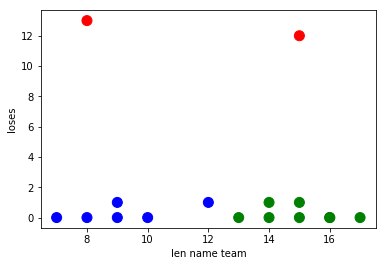

In [13]:
teams_pd.plot.scatter(x='len name team',y='loses', c=colors, s=100)

### Сделаем 5 кластеров

In [15]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 0.        ,  2.30258867],
        [ 0.06149481,  4.60517734],
        [ 0.12298962,  3.07011823],
        [ 3.19773023,  2.45609458],
        [ 2.95175098,  4.60517734]]),
 array([0, 0, 2, 1, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 4]))

In [16]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['r',
 'r',
 'b',
 'g',
 'b',
 'g',
 'b',
 'b',
 'g',
 'y',
 'g',
 'g',
 'g',
 'g',
 'g',
 'm']

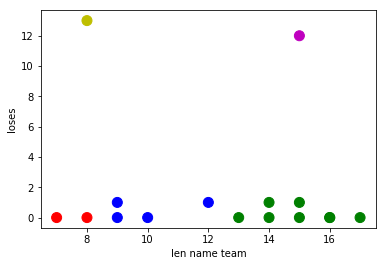

In [17]:
teams_pd.plot.scatter(x='len name team',y='loses', c=colors, s=100)